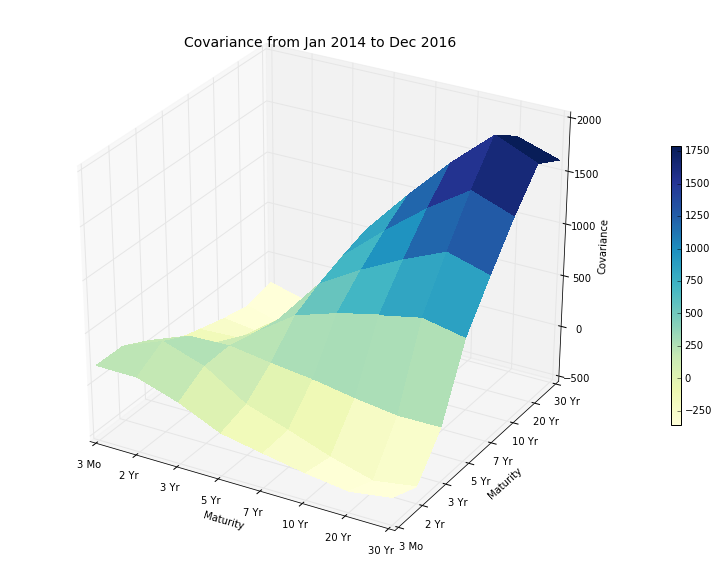

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import datetime as dt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec


from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA, KernelPCA

#Load data, clean, re-index, remove 1mo, 6mo, 20y, save to pickle. 

df = pd.read_csv("USTYields.csv", sep=",")
df = df.drop(["1 Mo", "6 Mo", "1 Yr"], 1)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
df.set_index("Date", drop=True, inplace=True)
df.loc[:] *= 100 #convert to basis points

df.to_pickle("RawData")

#Save data from 10years ago to now
start_date = dt.datetime(2006, 12, 8)
end_date = df.index[-1]
data = df[start_date:end_date]
splitDates = np.array_split(data, 5)

with open('splitData', 'w') as f:
    pickle.dump(splitDates, f)

    
############ Covariance Chart ##############

#choose last 2 years or so of data
start = dt.datetime(2014, 1, 5)
end = dt.datetime(2016, 12, 8)

raw = data[start:end]


meanVals = raw.mean()
demeaned = raw - meanVals
stDate, edDate = raw.index[0].strftime("%b %Y"), raw.index[-1].strftime("%b %Y")

#cov of data:
covM = raw.cov()
indexRef = covM.index
covM.index = range(len(covM))
covM.columns = covM.index

#generate X, Y, Z for cov plot:
X = covM.index
Y = covM.index
X, Y = np.meshgrid(X, Y)
zs = np.array([covM.iat[i, j] for i, j in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


#plot
plt.rcParams["font.family"] = "sans-serif"
fig = plt.figure(figsize=(14, 10), dpi=400)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.YlGnBu,linewidth=0,antialiased=False)

ax.set_xticklabels(indexRef)
ax.set_yticklabels(indexRef)
ax.set_xlabel('Maturity')
ax.set_ylabel('Maturity')
ax.set_zlabel('Covariance')
fig.colorbar(surf, shrink=0.5, aspect=30)

plt.title("Covariance from %s to %s" % (stDate, edDate), fontsize=14)

plt.savefig("Covariance.png")

plt.show()



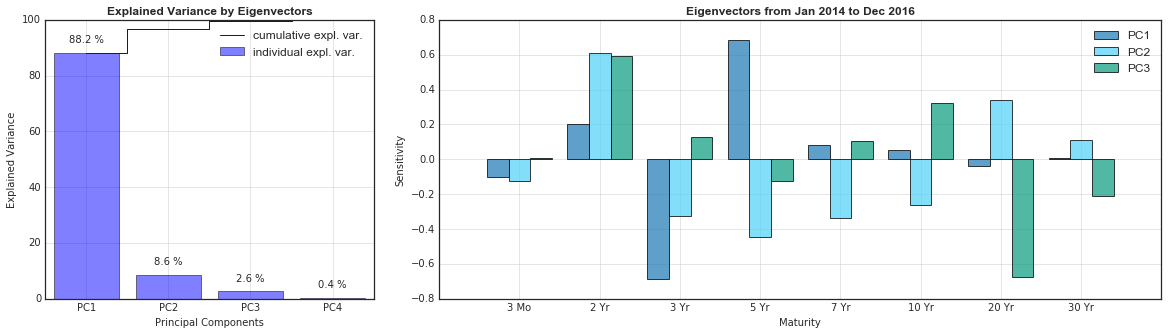

In [5]:
############ PCA ##############

# Eigenvalue decomp on Cov matrix:

evals, evecs = np.linalg.eig(covM)
#print ('Eigenvectors \n%s' %evecs)
#print ('Eigenvalues \n%s' %evals)

# Create evalue, evec pairs:
epairs = sorted(zip(evals, evecs))[::-1]
#print epairs

#normed evals
nevals = sorted([i*100/sum(evals) for i in evals])[::-1][:4]
cumExp = np.cumsum(nevals)
#print cumExp

#Eigenvector Dataframe
evTable = pd.DataFrame(index=indexRef)
for i in xrange(3):
    evTable.insert(i, "PC"+str(i+1), epairs[i][1])



#plot Expl. Variance
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(20, 5), dpi=400)
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax1.bar(range(4), nevals, alpha=0.5, align='center', label='individual expl. var.')
ax1.step(range(4), cumExp, where='mid', label='cumulative expl. var.')
ax1.set_xticks(range(4))
ax1.set_xticklabels(["PC1", "PC2", "PC3", "PC4"])
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance')
ax1.legend(loc="best")
ax1.set_title("Explained Variance by Eigenvectors", fontweight="bold")
ax1.grid()

rects = ax1.patches
labels = [str(round(i, 1))+" %" for i in nevals]

for rect,label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 3, label, ha='center', va='bottom')
    
    
    
#plot Eigenvectors
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
ax2.set_title("Eigenvectors from %s to %s"%(stDate, edDate), fontweight="bold")
ax2.grid()
bwidth = 0.27
adjpos = [-bwidth, 0, bwidth]
colors = ['#2980b9', '#58D3F7', '#16a085']
ind = np.arange(len(indexRef))
for col in xrange(len(evTable.columns)):
    ax2.bar(ind+adjpos[col], evTable.ix[:,col],alpha=0.75, width=bwidth,color=colors[col], align="center")
ax2.set_xlabel('Maturity')
ax2.set_ylabel('Sensitivity')
ax2.set_xticks(range(len(indexRef)))
ax2.set_xticklabels(indexRef)
ax2.legend(["PC1", "PC2", "PC3"])
plt.savefig("Eigenvectors.png")

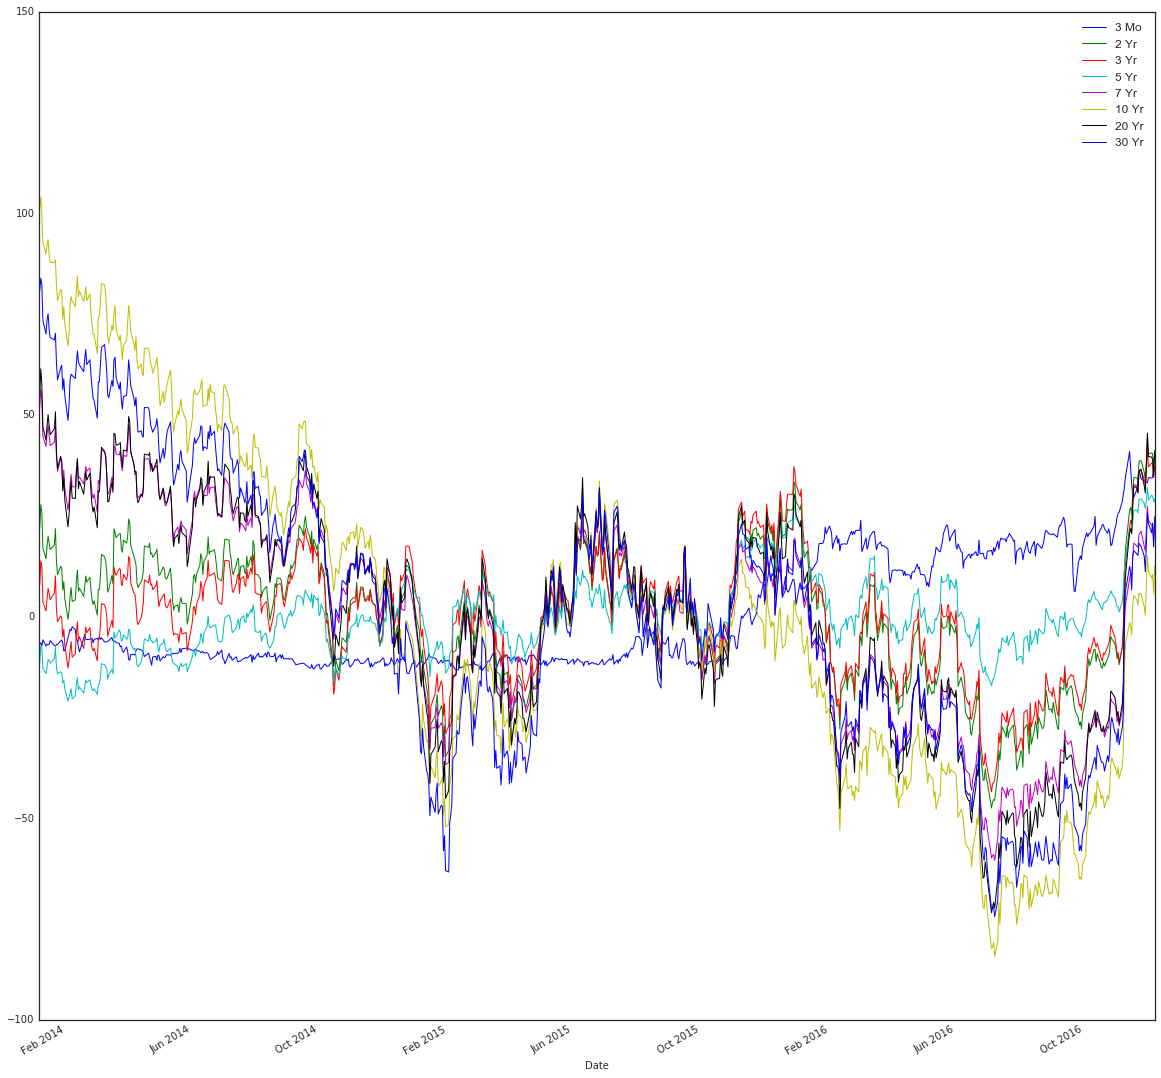

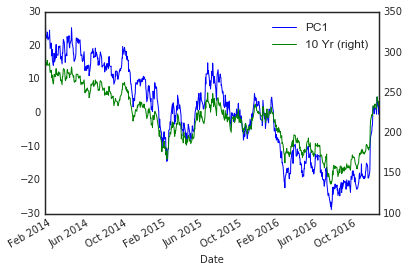

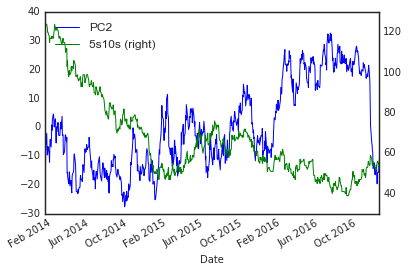

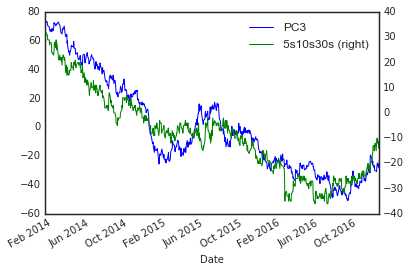

In [6]:
############ Reconstruct ##############


reconstr = demeaned.dot(evTable)
invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)
rebuildRaw = reconstr.dot(invEV)
residuals = pd.DataFrame()
residuals = demeaned - rebuildRaw
residuals.plot(figsize=(20,20))

testpc1 = pd.DataFrame()
testpc1["PC1"] = reconstr["PC1"] 
testpc1["10 Yr"] = raw["10 Yr"]
testpc1.plot(secondary_y='10 Yr')
testpc2 = pd.DataFrame()
testpc2["PC2"] = reconstr["PC2"] 
testpc2["5s10s"] = raw["10 Yr"]-raw["5 Yr"]
testpc2.plot(secondary_y='5s10s')
testpc3 = pd.DataFrame()
testpc3["PC3"] = -reconstr["PC3"] 
testpc3["5s10s30s"] = raw["10 Yr"]*2-raw["5 Yr"]-raw["30 Yr"]
testpc3.plot(secondary_y='5s10s30s')


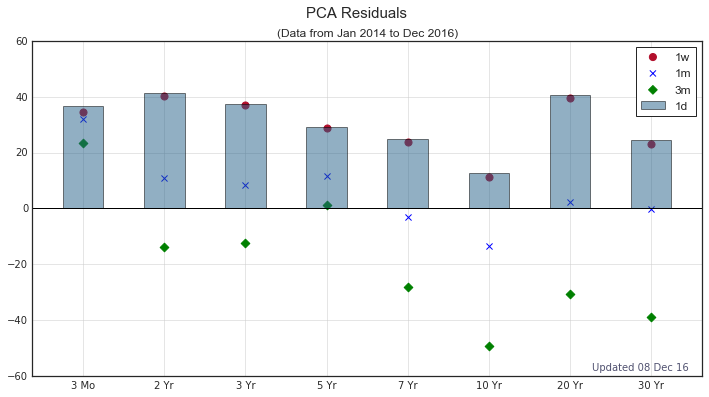

In [7]:
########### Residuals ############

relVal = pd.DataFrame()
relVal = residuals.ix[[-1, -5, -20, -60]]
relVal.index = ["1d", "1w", "1m", "3m"]
relVal = relVal.transpose()
#relVal.plot(kind="bar")

fig = plt.figure(figsize=(12, 6), dpi=400)
ax = fig.add_subplot(111)
xvals = range(len(indexRef))
ax.bar(xvals, relVal["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax.set_xticks(xvals)
ax.set_xticklabels(indexRef)
plt.grid()
s = 25
ax.scatter(xvals, relVal["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax.scatter(xvals, relVal["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax.scatter(xvals, relVal["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax.axhline(0, color="black")

plt.suptitle("PCA Residuals", fontsize=15)
plt.title("(Data from %s to %s)"%(stDate, edDate))
ax.text(0.98, 0.01, 'Updated %s'%(raw.index[-1].strftime("%d %b %y")),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#4f506f', fontsize=10)
ax.legend(frameon=True, loc="best")
plt.show()
